In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [17]:
train_dataset  = train_datagen.flow_from_directory(directory = r"C:\Users\hp\Downloads\Fer2013\train",
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 22968 images belonging to 7 classes.


In [18]:
valid_dataset = valid_datagen.flow_from_directory(directory = r"C:\Users\hp\Downloads\Fer2013\train",
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5741 images belonging to 7 classes.


In [19]:
test_dataset = test_datagen.flow_from_directory(directory = r"C:\Users\hp\Downloads\Fer2013\test",
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


In [20]:
base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

58889256/58889256 [==============================] - 4s 0us/step


In [21]:
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [22]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


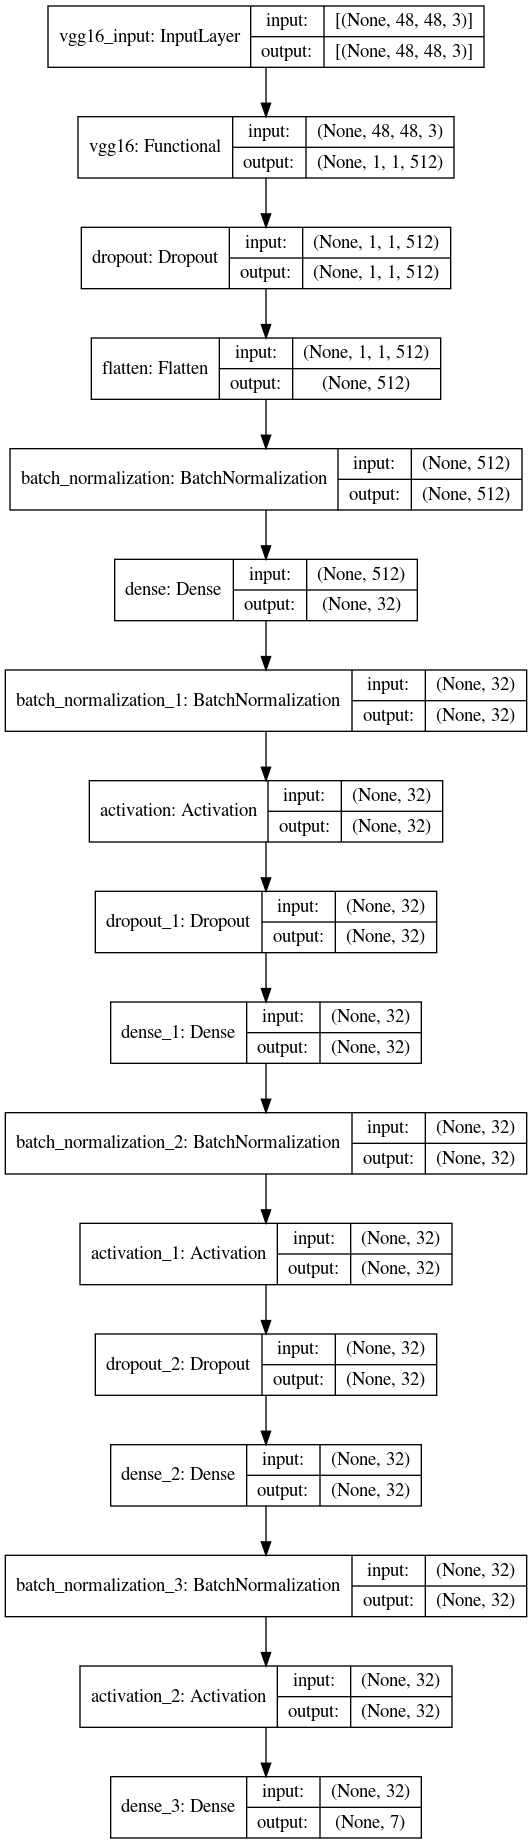

In [43]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file=r"C:\Users\hp\Downloads\convnet.png", show_shapes=True,show_layer_names=True)
Image(filename=r"C:\Users\hp\Downloads\convnet.png") 

In [32]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [33]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [34]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [47]:
model_json = model.to_json()
with open("model_arch.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("weights_min_loss.hdf5")
print("Saved model to disk")

Saved model to disk


In [35]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [36]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 5,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/5
359/359 [==============================] - 735s 2s/step - loss: 1.9512 - accuracy: 0.8545 - precision: 0.1705 - recall: 0.0048 - auc: 0.5946 - f1_score: 0.0090 - val_loss: 8.3225 - val_accuracy: 0.7460 - val_precision: 0.1106 - val_recall: 0.1104 - val_auc: 0.4933 - val_f1_score: 0.1103 - lr: 0.0010
Epoch 2/5
359/359 [==============================] - 505s 1s/step - loss: 1.8117 - accuracy: 0.8569 - precision: 0.3951 - recall: 0.0028 - auc: 0.6531 - f1_score: 0.0054 - val_loss: 1.8405 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6489 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/5
359/359 [==============================] - 512s 1s/step - loss: 1.7846 - accuracy: 0.8573 - precision: 0.5481 - recall: 0.0074 - auc: 0.6688 - f1_score: 0.0144 - val_loss: 1.8640 - val_accuracy: 0.8569 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6501 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/5
359/359 [========================

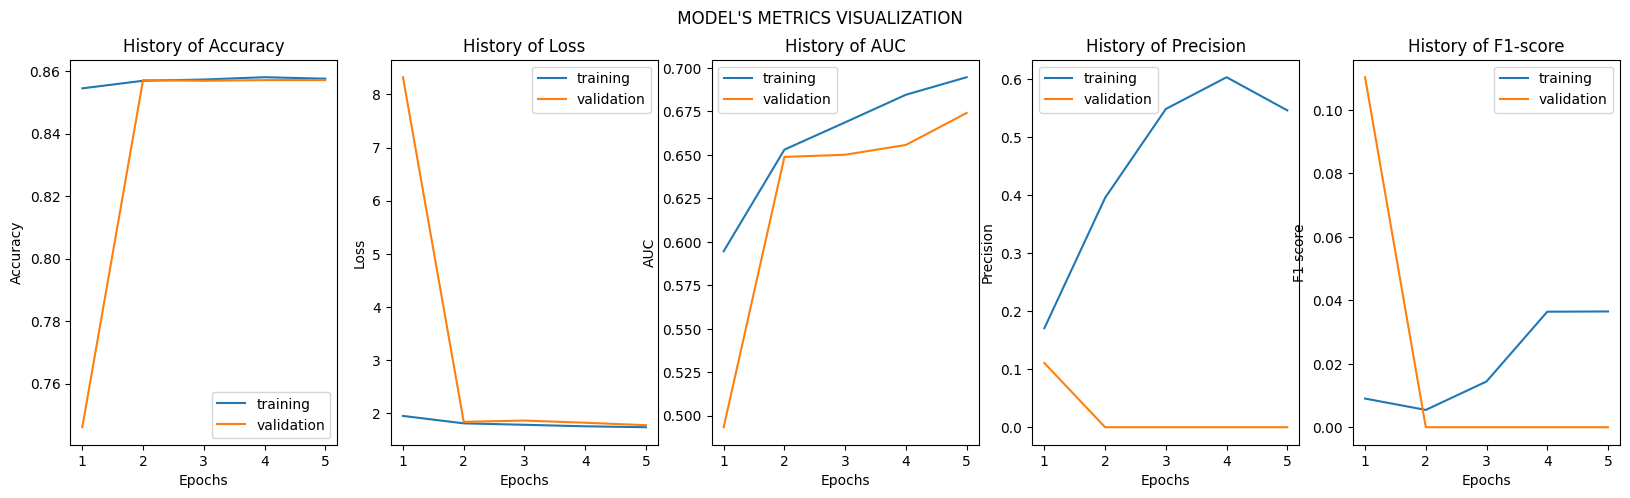

In [37]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing import image

model = load_model('D:\FERS-master\weights_min_loss.hdf5')
face_haar_cascade = cv2.CascadeClassifier(r"C:\Users\Manav\AppData\Local\Programs\Python\Python310\Lib\site-packages\cv2\data\haarcascade_frontalface_default.xml")
cap=cv2.VideoCapture(0)

while cap.isOpened():
    res,frame=cap.read()

    height, width , channel = frame.shape
    sub_img = frame[0:int(height/6),0:int(width)]

    black_rect = np.ones(sub_img.shape, dtype=np.uint8)*0
    res = cv2.addWeighted(sub_img, 0.77, black_rect,0.23, 0)
    FONT = cv2.FONT_HERSHEY_SIMPLEX
    FONT_SCALE = 0.8
    FONT_THICKNESS = 2
    lable_color = (10, 10, 255)
    lable = "Emotion Detection of Mrunmayee"
    lable_dimension = cv2.getTextSize(lable,FONT ,FONT_SCALE,FONT_THICKNESS)[0]
    textX = int((res.shape[1] - lable_dimension[0]) / 2)
    textY = int((res.shape[0] + lable_dimension[1]) / 2)
    cv2.putText(res, lable, (textX,textY), FONT, FONT_SCALE, (0,0,0), FONT_THICKNESS)
    gray_image= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_haar_cascade.detectMultiScale(gray_image)
    try:
        for (x,y, w, h) in faces:
            cv2.rectangle(frame, pt1 = (x,y),pt2 = (x+w, y+h), color = (255,0,0),thickness =  2)
            roi_gray = gray_image[y-5:y+h+5,x-5:x+w+5]
            roi_gray=cv2.resize(roi_gray,(48,48))
            image_pixels = img_to_array(roi_gray)
            image_pixels = np.expand_dims(image_pixels, axis = 0)
            image_pixels /= 255
            predictions = model.predict(image_pixels)
            max_index = np.argmax(predictions[0])
            emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
            emotion_prediction = emotion_detection[max_index]
            cv2.putText(res, "Sentiment: {}".format(emotion_prediction), (0,textY+22+5), FONT,0.7, lable_color,2)
            lable_violation = 'Confidence: {}'.format(str(np.round(np.max(predictions[0])*100,1))+ "%")
            violation_text_dimension = cv2.getTextSize(lable_violation,FONT,FONT_SCALE,FONT_THICKNESS )[0]
            violation_x_axis = int(res.shape[1]- violation_text_dimension[0])
            cv2.putText(res, lable_violation, (violation_x_axis,textY+22+5), FONT,0.7, lable_color,2)
    except :
        pass
    frame[0:int(height/6),0:int(width)] =res
    cv2.imshow('frame', frame)


    if cv2.waitKey(1) & 0xFF == ord('q'):
        break



cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 85ms/step
